### A few initial libraries ###

In [51]:
import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor

from qiskit import IBMQ
from qiskit.test.mock import FakeManhattan
from qiskit.test.mock import FakeBogota
from qiskit.test.mock import FakeMumbai
from qiskit.test.mock import FakeTokyo
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel



from gate_variants.toffoli_variants import CCX_Variant_Gate 
from orientation_map import orientation_map_gen
from trios_bench.cnx_halfdirty import generate_cnx_halfdirty
from trios_bench.cnx_dirty import generate_dirty_multicontrol
from trios_bench.cuccaro_adder import generate_cuccaro_adder

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.18.3', 'qiskit-aer': '0.9.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.18.1', 'qiskit-aqua': '0.9.5', 'qiskit': '0.32.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

### Load device and the device configuration object ###

In [3]:
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q-ornl')
# device = FakeMumbai()

# backend_prop = device.properties()

In [4]:
from qiskit_superstaq.superstaq_provider import SuperstaQProvider

In [5]:
superstaq_provider = SuperstaQProvider(api_key="ya29.A0ARrdaM-BWPjpkjhKgbVSRwWROaVE3g6mKCew2all4yXuPNLIwc6l65K10DiAMa-w8he0mR-i0Tb_jE6-GqqWlscj9Zq58rC2oSSzRVaLdZJMoy2bWqIXVhK3Tehp5N4zd8uHhyp01G9KC90Xmu3BKALiGiLP-w")

In [6]:
from level3_context import _parse_transpile_args, level_3_context_pass_manager
from level3_context_pulse import level_3_pass_manager, level_3_orign_pulse_pass_manager, level_3_context_pulse_pass_manager, level_3_pulse_pass_manager

In [7]:
qc = QuantumCircuit(5, 5)
# qc.cx(0,3)
# qc.cx(1,2)
# qc.h(2)
# qc.ccx(0,1,2)
# qc.x(1)
# qc.cx(1,2)
# qc.cx(0,1)
# qc.z(0)
# qc.ccx(0,1,2)
# qc.x(1)
# qc.cx(1,2)
qc.rx(np.pi/3, 0)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(0,1)
#

In [57]:
qc =  generate_cnx_halfdirty(5)
qc.measure_all()

In [58]:
qc.draw()

░ ┌─┐            
   q_0: ───────■─────────■───░─┤M├────────────
               │         │   ░ └╥┘┌─┐         
   q_1: ───────■─────────■───░──╫─┤M├─────────
               │         │   ░  ║ └╥┘┌─┐      
   q_2: ──■────┼────■────┼───░──╫──╫─┤M├──────
        ┌─┴─┐  │  ┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
   q_3: ┤ X ├──┼──┤ X ├──┼───░──╫──╫──╫─┤M├───
        └─┬─┘┌─┴─┐└─┬─┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ──■──┤ X ├──■──┤ X ├─░──╫──╫──╫──╫─┤M├
             └───┘     └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/════════════════════════╩══╩══╩══╩══╩═
                                0  1  2  3  4

In [59]:
qc.count_ops()

OrderedDict([('measure', 5), ('ccx', 4), ('barrier', 1)])

In [60]:
backend = provider.get_backend('ibmq_jakarta')

In [61]:
backend_prop = backend.properties()

In [62]:
orientation_map = orientation_map_gen(backend)

In [63]:
coupling_map = [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 5], [4, 5], [5, 3], [5, 4], [5, 6], [6, 5]]

In [64]:
transpile_args = _parse_transpile_args([qc], backend = None, coupling_map = coupling_map, basis_gates = ['cx', 'rz', 'sx', 'x', 'acecr_pm'], seed_transpiler = 0, orientation_map = orientation_map)

In [65]:
pass_manager_config = transpile_args[0]['pass_manager_config']

In [66]:
print(pass_manager_config.orientation_map)

{(0, 1): 'f', (1, 0): 'b', (1, 2): 'b', (1, 3): 'f', (2, 1): 'f', (3, 1): 'b', (3, 5): 'f', (4, 5): 'b', (5, 3): 'b', (5, 4): 'f', (5, 6): 'b', (6, 5): 'f'}


In [67]:
pm_context = level_3_context_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [68]:
pm_orign = level_3_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [69]:
pm_orign_pulse = level_3_orign_pulse_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [70]:
pm_context_pulse = level_3_context_pulse_pass_manager(pass_manager_config)

layout_method:  dense
routing method:  basic


In [71]:
qc_context_pulse = pm_context_pulse.run(qc)

ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
5: Qubit(QuantumRegister(5, 'q'), 0),
3: Qubit(QuantumRegister(5, 'q'), 1),
2: Qubit(QuantumRegister(5, 'q'), 2),
1: Qubit(QuantumRegister(5, 'q'), 3),
0: Qubit(QuantumRegister(5, 'q'), 4)
})
The physical qubits for the toffoli are:  0 2 1
The required toffoli will be decomposed using an 8 cnot decomposition - two in center
ccx
three intersection conditions False True False
three qargs Qubit(QuantumRegister(7, 'q'), 0) Qubit(QuantumRegister(7, 'q'), 2) Qubit(QuantumRegister(7, 'q'), 1)
calculated tags ['00', '00', 'l2', 'p'] ['00', '00', 'l2', 'p']
swap
successor swap two intersection conditions:TrueTrue
initialized variant_tag: ('00', '02', 'l2', 's')
The physical qubits for the toffoli are:  5 3 1
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
ccx
three intersection conditions True True False
three qargs Qubit(QuantumRegister(7, 'q'), 5) Qubit(QuantumRegister(7, 'q'), 3) Qubit(Qua

In [72]:
qc_context_pulse.draw()

global phase: 2π
                                                              ┌───────────┐»
      q_4 -> 0 ───────────────────────────────────────────────┤0          ├»
                                ┌───────────┐┌─────────┐┌────┐│  Acecr_pm │»
      q_3 -> 1 ─────────────────┤1          ├┤ Rz(π/2) ├┤ √X ├┤1          ├»
               ┌─────────┐┌────┐│  Acecr_pm │├─────────┤├────┤└┬─────────┬┘»
      q_2 -> 2 ┤ Rz(π/2) ├┤ √X ├┤0          ├┤ Rz(π/2) ├┤ √X ├─┤ Rz(π/4) ├─»
               ├─────────┤├────┤└┬─────────┬┘└─────────┘└────┘ └─────────┘ »
      q_1 -> 3 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π/2) ├───────────────────────────────»
               └─────────┘└────┘ └─────────┘                               »
ancilla_0 -> 4 ────────────────────────────────────────────────────────────»
               ┌─────────┐┌────┐ ┌─────────┐                               »
      q_0 -> 5 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π/2) ├───────────────────────────────»
               └─────────┘└────┘ └─────────┘                               »
ancilla_1 -> 6 ────────────────────────────────────────────────────────────»
                                                                           »
       meas: 5/════════════════════════════════════════════════════════════»
                                                                           »
«                                                                         »
«      q_4 -> 0 ──────────────────────────────────────────────────────────»
«               ┌─────────┐┌────┐┌───────────┐┌─────────┐┌────┐┌─────────┐»
«      q_3 -> 1 ┤ Rz(π/2) ├┤ √X ├┤1          ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/4) ├»
«               └──┬────┬─┘└────┘│  Acecr_pm │├─────────┤├────┤├─────────┤»
«      q_2 -> 2 ───┤ √X ├────────┤0          ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/4) ├»
«                  └────┘        └───────────┘└─────────┘└────┘└─────────┘»
«      q_1 -> 3 ──────────────────────────────────────────────────────────»
«                                                                         »
«ancilla_0 -> 4 ──────────────────────────────────────────────────────────»
«                                                                         »
«      q_0 -> 5 ──────────────────────────────────────────────────────────»
«                                                                         »
«ancilla_1 -> 6 ──────────────────────────────────────────────────────────»
«                                                                         »
«       meas: 5/══════════════════════════════════════════════════════════»
«                                                                         »
«                     ┌───────────┐   ┌───┐   ┌─────────┐           »
«      q_4 -> 0 ──────┤0          ├───┤ X ├───┤ Rz(π/2) ├───────────»
«               ┌────┐│  Acecr_pm │┌──┴───┴──┐└──┬────┬─┘┌─────────┐»
«      q_3 -> 1 ┤ √X ├┤1          ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├»
«               ├────┤└───────────┘└─────────┘   └────┘  └─────────┘»
«      q_2 -> 2 ┤ √X ├──────────────────────────────────────────────»
«               └────┘                                              »
«      q_1 -> 3 ────────────────────────────────────────────────────»
«                                                                   »
«ancilla_0 -> 4 ────────────────────────────────────────────────────»
«                                                                   »
«      q_0 -> 5 ────────────────────────────────────────────────────»
«                                                                   »
«ancilla_1 -> 6 ────────────────────────────────────────────────────»
«                                                                   »
«       meas: 5/════════════════════════════════════════════════════»
«                                                                   »
«                                                   ┌───────────┐»
«      q_4 -> 0 ────────────────────────────────────┤0          ├»
«               ┌───────────┐   ┌───┐   ┌──────────┐│  Ace

In [73]:
qc_context_pulse.count_ops()

OrderedDict([('rz', 84),
             ('sx', 63),
             ('acecr_pm', 31),
             ('x', 7),
             ('measure', 5),
             ('barrier', 1)])

In [74]:
qc_orign_pulse = pm_orign_pulse.run(qc)

ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
5: Qubit(QuantumRegister(5, 'q'), 0),
3: Qubit(QuantumRegister(5, 'q'), 1),
2: Qubit(QuantumRegister(5, 'q'), 2),
1: Qubit(QuantumRegister(5, 'q'), 3),
0: Qubit(QuantumRegister(5, 'q'), 4)
})
The physical qubits for the toffoli are:  0 2 1
The required toffoli will be decomposed using an 8 cnot decomposition - two in center
The physical qubits for the toffoli are:  5 3 1
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
The physical qubits for the toffoli are:  1 2 0
The required toffoli will be decomposed using an 8 cnot decomposition - zero in center
The physical qubits for the toffoli are:  5 3 1
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', '11', 'b')
('11', '00', 'f')
('00', 

In [75]:
qc_orign_pulse.count_ops()

OrderedDict([('rz', 111),
             ('sx', 69),
             ('acecr_pm', 35),
             ('x', 23),
             ('measure', 5),
             ('barrier', 1)])

In [76]:
qc_orign_pulse.draw()

global phase: 5π/4
                  ┌───┐    ┌─────────┐                         ┌───────────┐»
      q_4 -> 0 ───┤ X ├────┤ Rz(π/4) ├─────────────────────────┤0          ├»
               ┌──┴───┴──┐ └──┬────┬─┘┌──────────┐    ┌────┐   │  Acecr_pm │»
      q_3 -> 1 ┤ Rz(π/2) ├────┤ √X ├──┤ Rz(3π/4) ├────┤ √X ├───┤1          ├»
               ├─────────┴┐   ├────┤  └──────────┘    └────┘   └───────────┘»
      q_2 -> 2 ┤ Rz(3π/4) ├───┤ √X ├────────────────────────────────────────»
               ├──────────┤   ├────┤              ┌───────────┐    ┌───┐    »
      q_1 -> 3 ┤ Rz(3π/4) ├───┤ √X ├──────────────┤0          ├────┤ X ├────»
               └──────────┘   └────┘              │           │    └───┘    »
ancilla_0 -> 4 ───────────────────────────────────┤  Acecr_pm ├─────────────»
                ┌────────┐    ┌────┐  ┌─────────┐ │           │  ┌────────┐ »
      q_0 -> 5 ─┤ Rz(-π) ├────┤ √X ├──┤ Rz(π/2) ├─┤1          ├──┤ Rz(-π) ├─»
                └────────┘    └────┘  └─────────┘ └───────────┘  └────────┘ »
ancilla_1 -> 6 ─────────────────────────────────────────────────────────────»
                                                                            »
       meas: 5/═════════════════════════════════════════════════════════════»
                                                                            »
«                  ┌───┐   ┌─────────┐                                   »
«      q_4 -> 0 ───┤ X ├───┤ Rz(π/2) ├───────────────────────────────────»
«               ┌──┴───┴──┐└──┬────┬─┘┌─────────┐┌───────────┐   ┌───┐   »
«      q_3 -> 1 ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├┤1          ├───┤ X ├───»
«               └─────────┘   └────┘  └─────────┘│  Acecr_pm │┌──┴───┴──┐»
«      q_2 -> 2 ─────────────────────────────────┤0          ├┤ Rz(π/2) ├»
«                                                └───────────┘└─────────┘»
«      q_1 -> 3 ─────────────────────────────────────────────────────────»
«                                                                        »
«ancilla_0 -> 4 ─────────────────────────────────────────────────────────»
«                  ┌────┐   ┌────────┐                                   »
«      q_0 -> 5 ───┤ √X ├───┤ Rz(-π) ├───────────────────────────────────»
«                  └────┘   └────────┘                                   »
«ancilla_1 -> 6 ─────────────────────────────────────────────────────────»
«                                                                        »
«       meas: 5/═════════════════════════════════════════════════════════»
«                                                                        »
«                           ┌───────────┐   ┌───┐   ┌─────────┐           »
«      q_4 -> 0 ────────────┤0          ├───┤ X ├───┤ Rz(π/2) ├───────────»
«               ┌──────────┐│  Acecr_pm │┌──┴───┴──┐└──┬────┬─┘┌─────────┐»
«      q_3 -> 1 ┤ Rz(-π/2) ├┤1          ├┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├»
«               └──┬────┬──┘└┬─────────┬┘└──┬────┬─┘   └────┘  └─────────┘»
«      q_2 -> 2 ───┤ √X ├────┤ Rz(π/4) ├────┤ √X ├────────────────────────»
«                  └────┘    └─────────┘    └────┘                        »
«      q_1 -> 3 ──────────────────────────────────────────────────────────»
«                                                                         »
«ancilla_0 -> 4 ──────────────────────────────────────────────────────────»
«                                                                         »
«      q_0 -> 5 ──────────────────────────────────────────────────────────»
«                                                                         »
«ancilla_1 -> 6 ──────────────────────────────────────────────────────────»
«                                                                         »
«       meas: 5/══════════════════════════════════════════════════════════»
«                                                                         »
«                                                   ┌───────────┐   ┌───┐   »
«      q_4

In [77]:
qc_context = pm_context.run(qc)

ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
5: Qubit(QuantumRegister(5, 'q'), 0),
3: Qubit(QuantumRegister(5, 'q'), 1),
2: Qubit(QuantumRegister(5, 'q'), 2),
1: Qubit(QuantumRegister(5, 'q'), 3),
0: Qubit(QuantumRegister(5, 'q'), 4)
})
The physical qubits for the toffoli are:  0 2 1
The required toffoli will be decomposed using an 8 cnot decomposition - two in center
ccx
three intersection conditions False True False
three qargs Qubit(QuantumRegister(7, 'q'), 0) Qubit(QuantumRegister(7, 'q'), 2) Qubit(QuantumRegister(7, 'q'), 1)
calculated tags ['00', '00', 'l2', 'p'] ['00', '00', 'l2', 'p']
swap
successor swap two intersection conditions:TrueTrue
initialized variant_tag: ('00', '02', 'l2', 's')
The physical qubits for the toffoli are:  5 3 1
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
ccx
three intersection conditions True True False
three qargs Qubit(QuantumRegister(7, 'q'), 5) Qubit(QuantumRegister(7, 'q'), 3) Qubit(Qua

/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/qiskit-terra/lib/python3.7/site-packages/sympy/core/expr.py:3951: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  deprecated_since_version="1.9").warn()


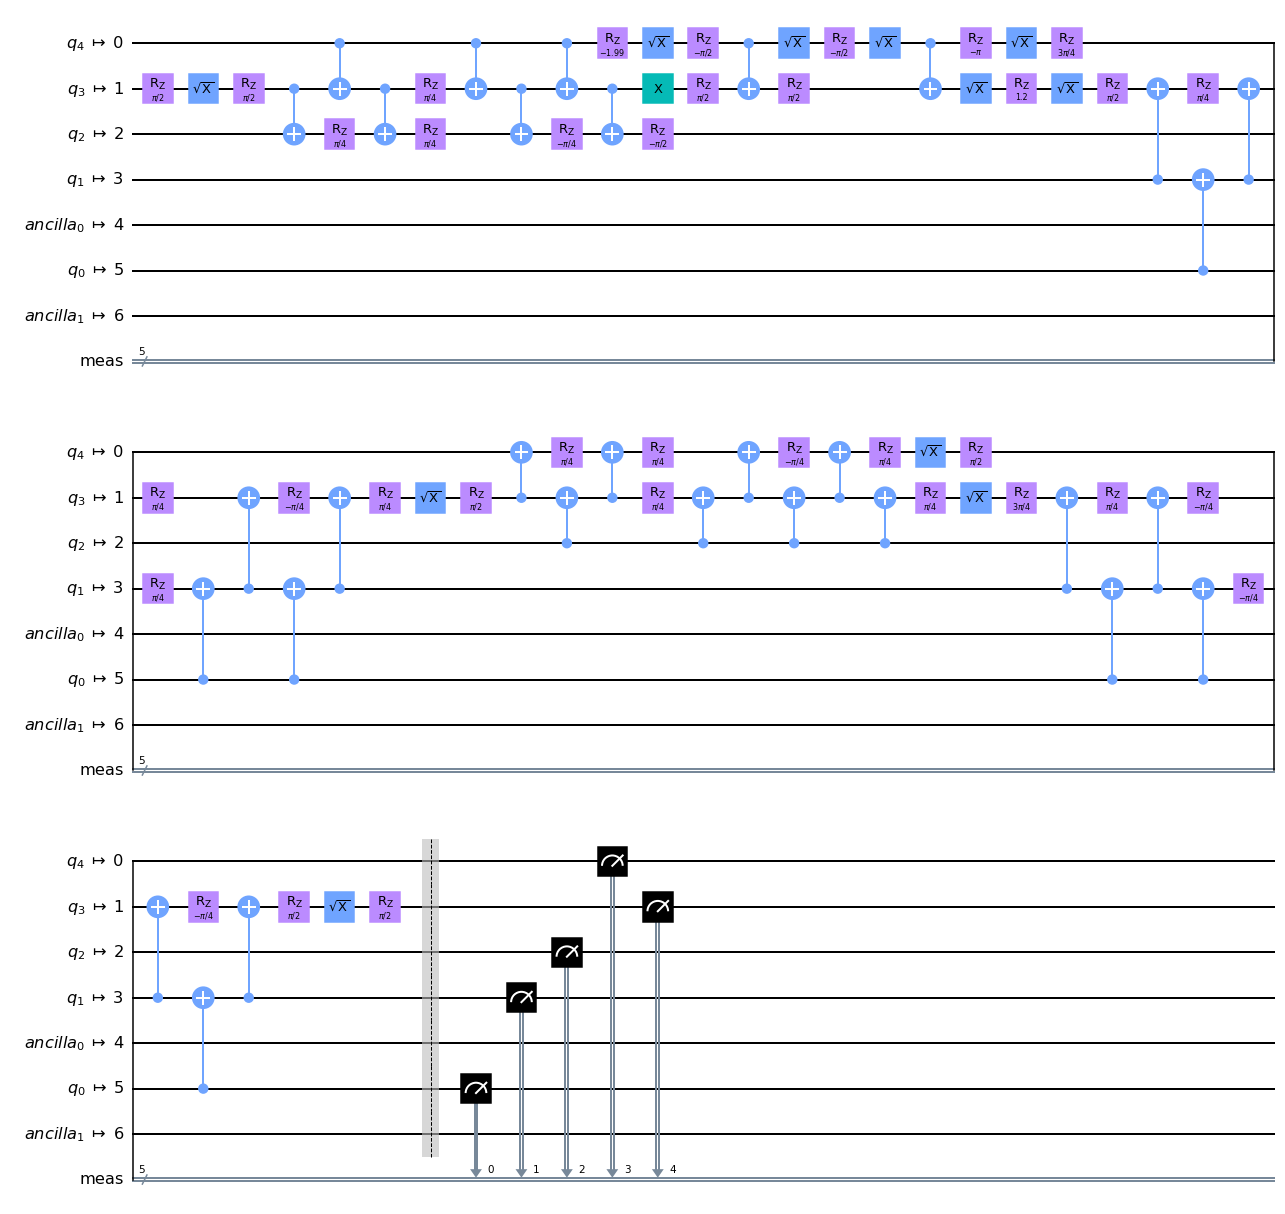

In [78]:
qc_context.draw(output = 'mpl')

In [79]:
qc_context.count_ops()

OrderedDict([('rz', 36),
             ('cx', 31),
             ('sx', 11),
             ('measure', 5),
             ('x', 1),
             ('barrier', 1)])

In [80]:
qc_orign = pm_orign.run(qc)

ccx
ccx
ccx
ccx
No solution found:  nonexistent solution
Layout({
5: Qubit(QuantumRegister(5, 'q'), 0),
3: Qubit(QuantumRegister(5, 'q'), 1),
2: Qubit(QuantumRegister(5, 'q'), 2),
1: Qubit(QuantumRegister(5, 'q'), 3),
0: Qubit(QuantumRegister(5, 'q'), 4)
})
The physical qubits for the toffoli are:  0 2 1
The required toffoli will be decomposed using an 8 cnot decomposition - two in center
The physical qubits for the toffoli are:  5 3 1
The required toffoli will be decomposed using an 8 cnot decomposition - one in center
The physical qubits for the toffoli are:  1 2 0
The required toffoli will be decomposed using an 8 cnot decomposition - zero in center
The physical qubits for the toffoli are:  5 3 1
The required toffoli will be decomposed using an 8 cnot decomposition - one in center


In [81]:
qc_orign.count_ops()

OrderedDict([('rz', 38),
             ('cx', 35),
             ('sx', 8),
             ('measure', 5),
             ('barrier', 1)])

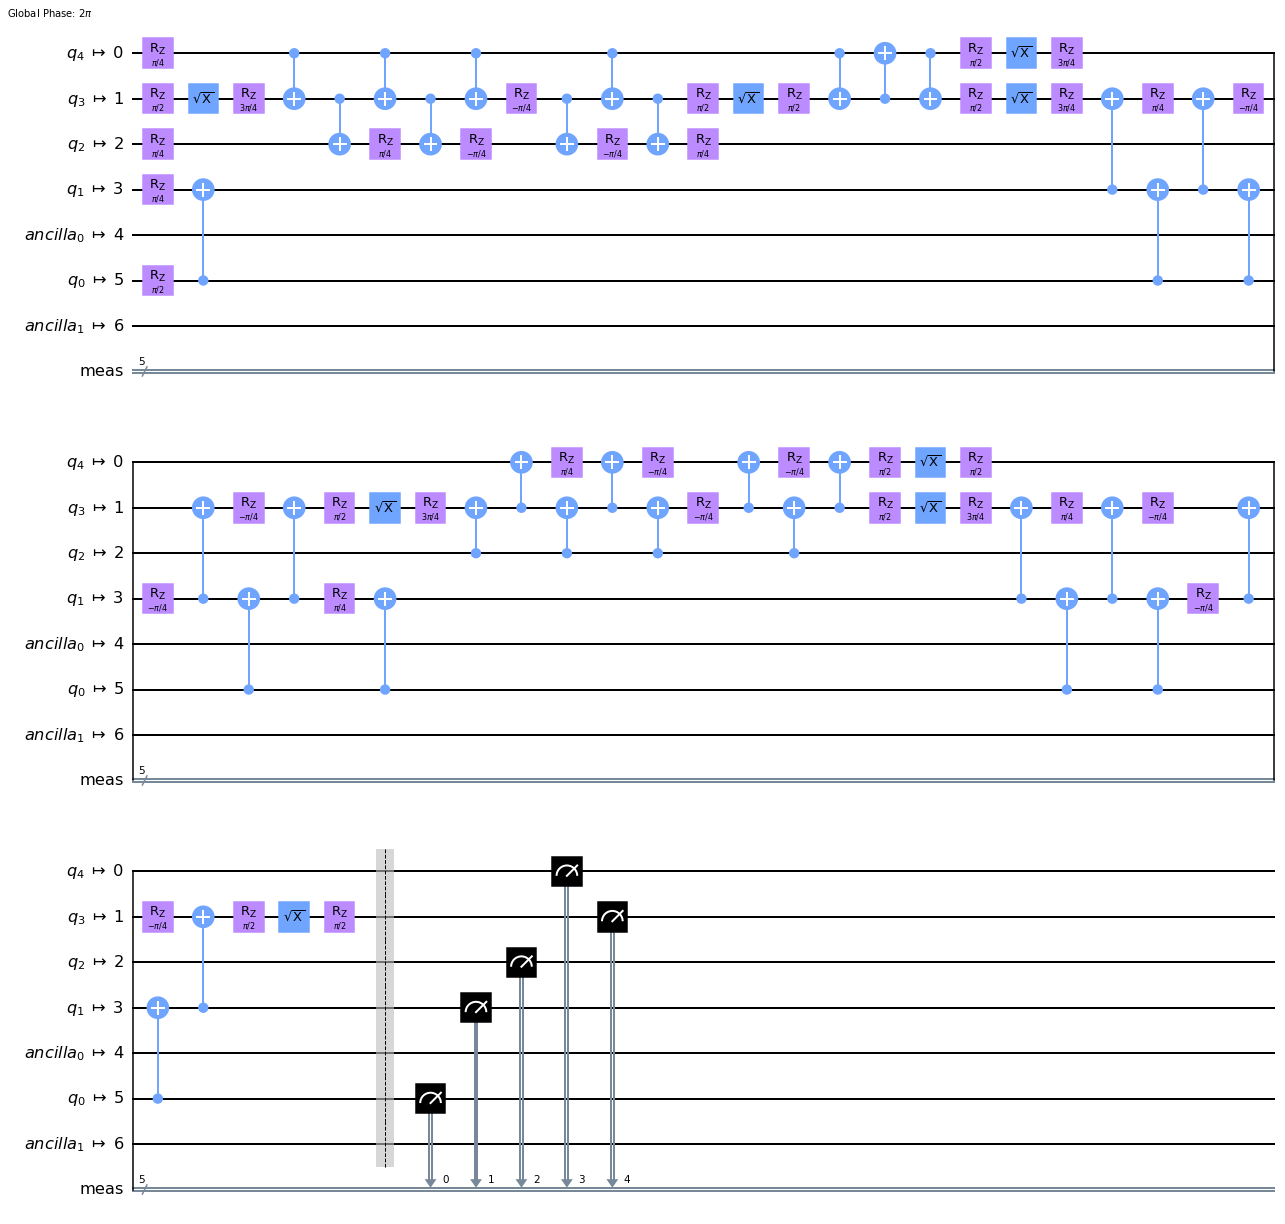

In [82]:
qc_orign.draw(output='mpl')

In [83]:
from qiskit_superstaq.superstaq_provider import SuperstaQProvider
import cirq

In [84]:
superstaq_provider = SuperstaQProvider(api_key="ya29.A0ARrdaM-BWPjpkjhKgbVSRwWROaVE3g6mKCew2all4yXuPNLIwc6l65K10DiAMa-w8he0mR-i0Tb_jE6-GqqWlscj9Zq58rC2oSSzRVaLdZJMoy2bWqIXVhK3Tehp5N4zd8uHhyp01G9KC90Xmu3BKALiGiLP-w")

In [85]:
orign_pulse_out = superstaq_provider.ibmq_compile(qc_orign_pulse, target="ibmq_jakarta_qpu")

In [86]:
context_pulse_out = superstaq_provider.ibmq_compile(qc_context_pulse, target="ibmq_jakarta_qpu")

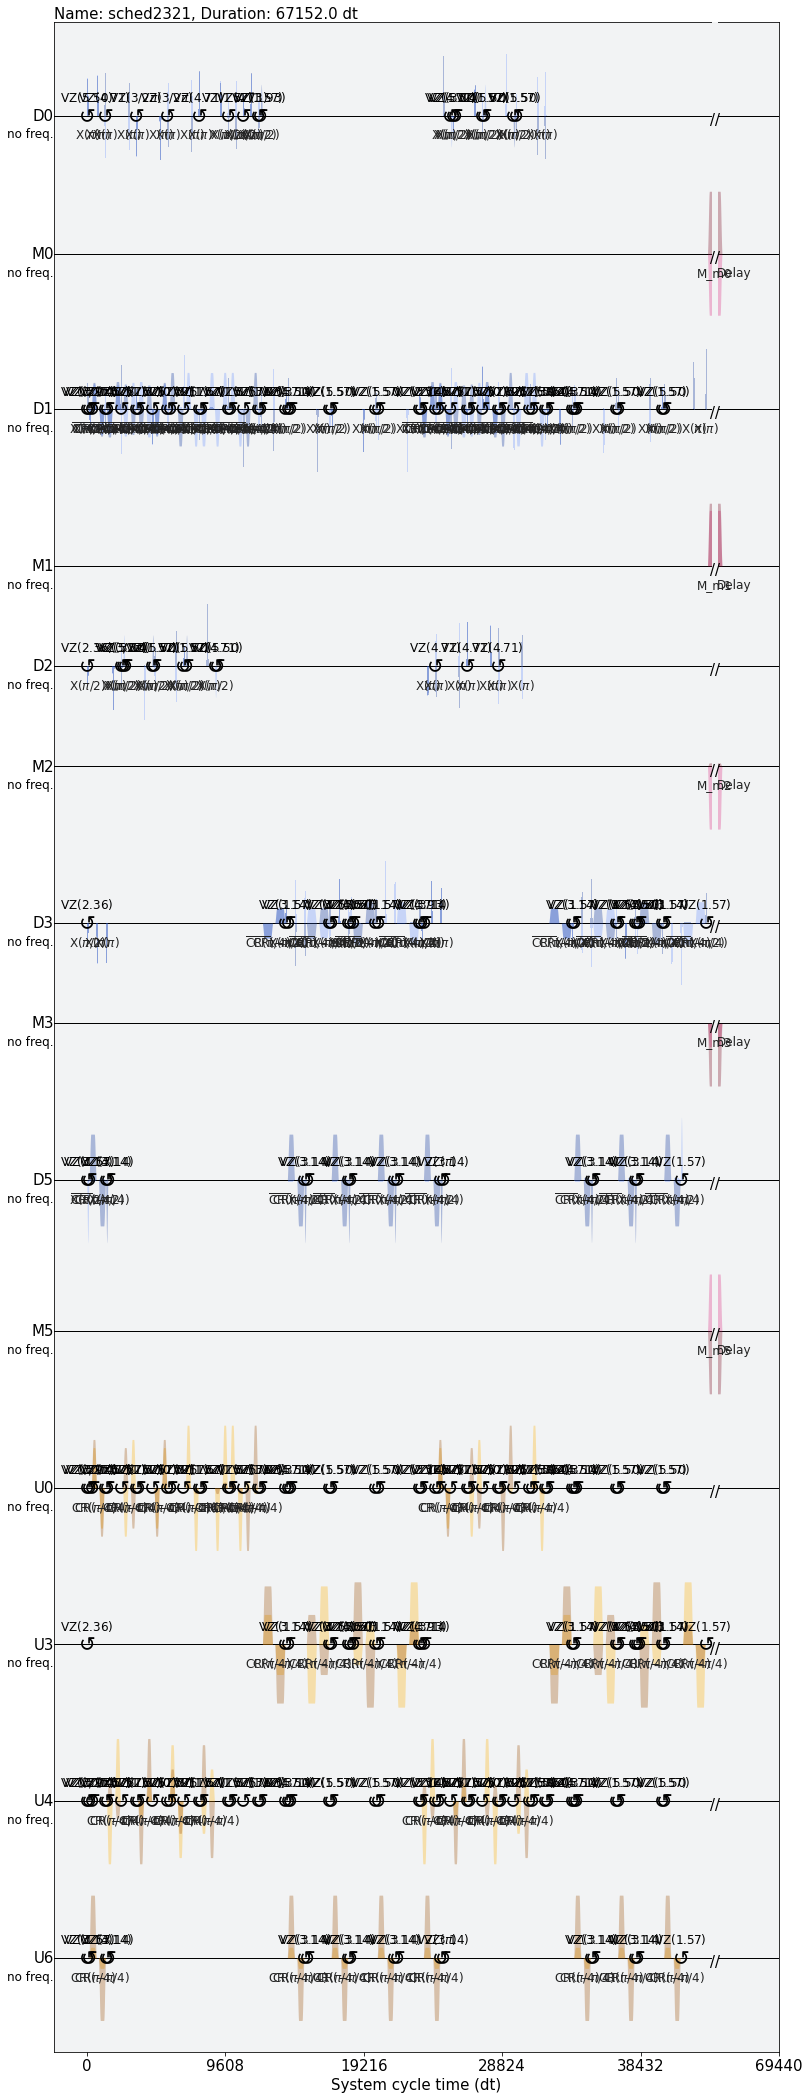

In [87]:
orign_pulse_out.pulse_sequence.draw()

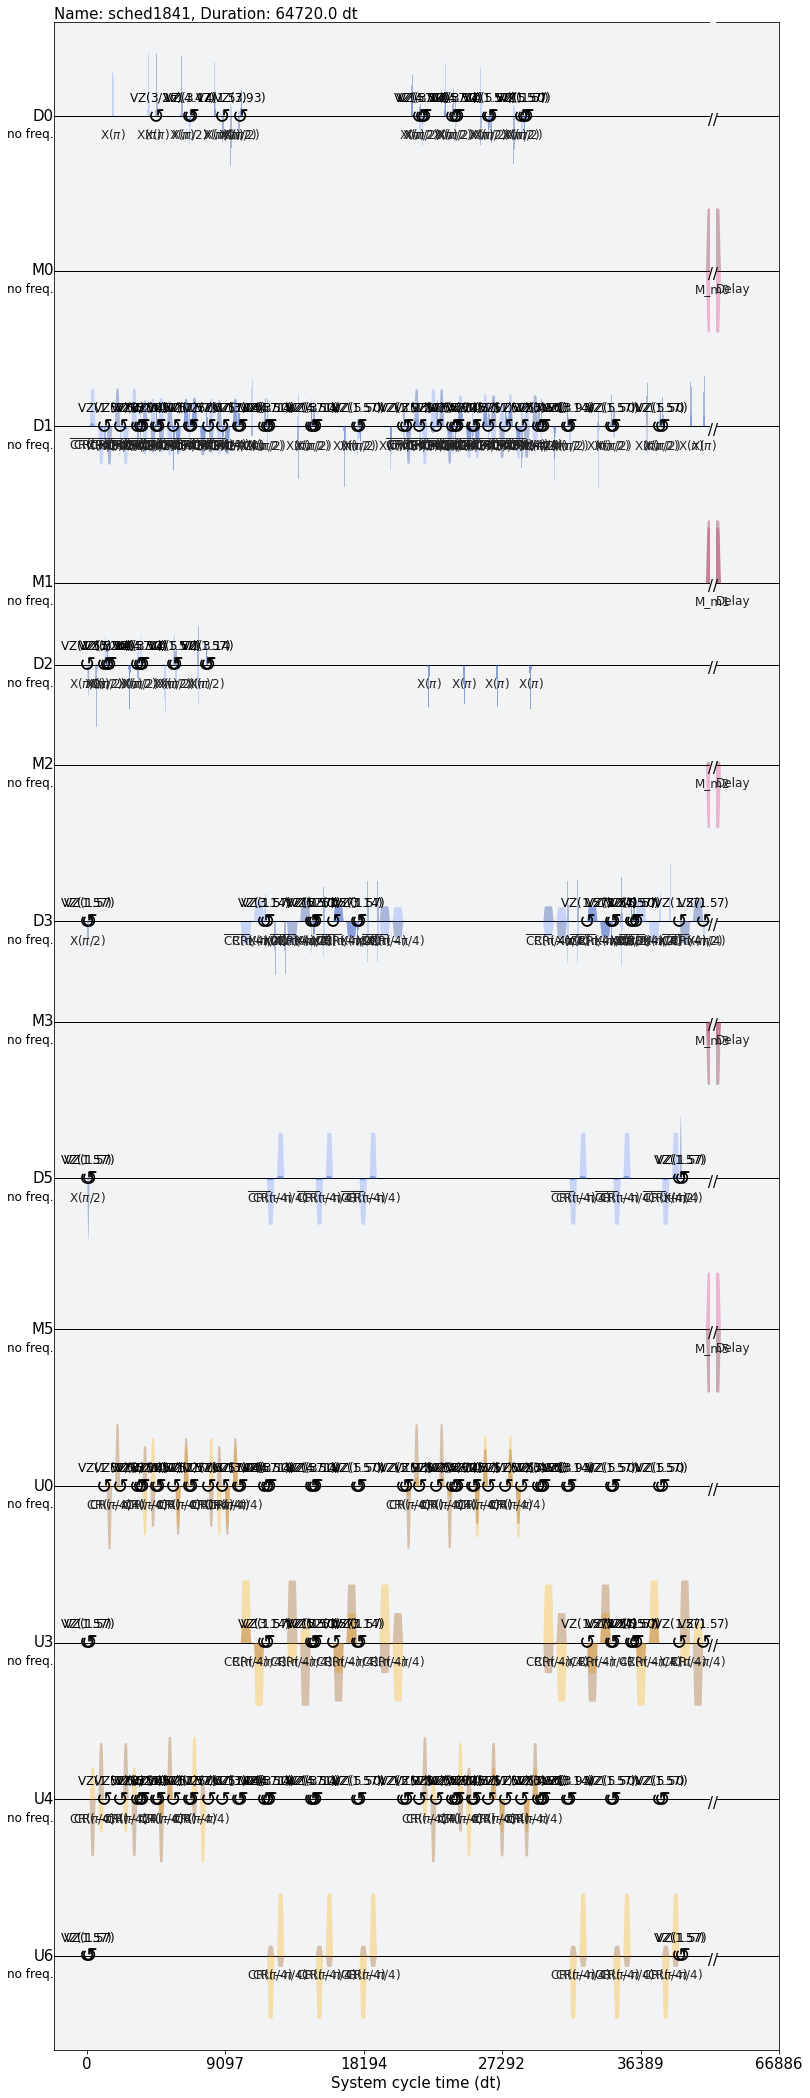

In [88]:
context_pulse_out.pulse_sequence.draw()

In [89]:
orign_pulse_out.circuit.draw()

┌──────────┐   ┌───┐                                     ┌───────────┐»
q_0: ┤ Rz(7π/4) ├───┤ X ├─────────────────────────────────────┤0          ├»
     ├──────────┤┌──┴───┴──┐┌──────────┐ ┌─────────┐ ┌───────┐│  Acecr_pm │»
q_1: ┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ Rz(5π/4) ├─┤ Rx(π/2) ├─┤ Rz(π) ├┤1          ├»
     ├──────────┤├─────────┤└──────────┘ └─────────┘ └───────┘└───────────┘»
q_2: ┤ Rz(3π/4) ├┤ Rx(π/2) ├───────────────────────────────────────────────»
     ├──────────┤├─────────┤            ┌───────────┐  ┌───┐               »
q_3: ┤ Rz(3π/4) ├┤ Rx(π/2) ├────────────┤0          ├──┤ X ├───────────────»
     └──────────┘└─────────┘            │           │  └───┘               »
q_4: ───────────────────────────────────┤  Acecr_pm ├──────────────────────»
      ┌───────┐  ┌─────────┐┌─────────┐ │           │┌───────┐ ┌─────────┐ »
q_5: ─┤ Rz(π) ├──┤ Rx(π/2) ├┤ Rz(π/2) ├─┤1          ├┤ Rz(π) ├─┤ Rx(π/2) ├─»
      └───────┘  └─────────┘└─────────┘ └───────────┘└───────┘ └─────────┘ »
q_6: ──────────────────────────────────────────────────────────────────────»
                                                                           »
c: 7/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌──────────┐   ┌───┐                                                  »
«q_0: ┤ Rz(3π/2) ├───┤ X ├──────────────────────────────────────────────────»
«     ├─────────┬┘┌──┴───┴──┐┌─────────┐┌───────────┐┌─────────┐    ┌───┐   »
«q_1: ┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(π/2) ├────┤ X ├───»
«     └─────────┘ └─────────┘└─────────┘│  Acecr_pm │├─────────┴┐┌──┴───┴──┐»
«q_2: ──────────────────────────────────┤0          ├┤ Rz(3π/2) ├┤ Rx(π/2) ├»
«                                       └───────────┘└──────────┘└─────────┘»
«q_3: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_4: ──────────────────────────────────────────────────────────────────────»
«      ┌───────┐                                                            »
«q_5: ─┤ Rz(π) ├────────────────────────────────────────────────────────────»
«      └───────┘                                                            »
«q_6: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«c: 7/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«     ┌───────────┐┌──────────┐   ┌───┐                                      »
«q_0: ┤0          ├┤ Rz(3π/2) ├───┤ X ├──────────────────────────────────────»
«     │  Acecr_pm │├─────────┬┘┌──┴───┴──┐┌─────────┐┌───────────┐┌─────────┐»
«q_1: ┤1          ├┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(π/2) ├»
«     └┬──────────┤├─────────┤ └┬───────┬┘└─────────┘│  Acecr_pm │├─────────┤»
«q_2: ─┤ Rz(7π/4) ├┤ Rx(π/2) ├──┤ Rz(π) ├────────────┤0          ├┤ Rz(π/2) ├»
«      └──────────┘└─────────┘  └───────┘            └───────────┘└─────────┘»
«q_3: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_4: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_5: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_6: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«c: 7/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                ┌─────────

In [90]:
context_pulse_out.circuit.draw()

┌───────────┐»
q_0: ──────────────────────────────────────────────────────────┤0          ├»
                           ┌───────────┐┌─────────┐ ┌─────────┐│  Acecr_pm │»
q_1: ──────────────────────┤1          ├┤ Rz(π/2) ├─┤ Rx(π/2) ├┤1          ├»
     ┌─────────┐┌─────────┐│  Acecr_pm │├─────────┴┐├─────────┤└┬──────────┤»
q_2: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤0          ├┤ Rz(3π/2) ├┤ Rx(π/2) ├─┤ Rz(7π/4) ├»
     ├─────────┤├─────────┤└┬─────────┬┘└──────────┘└─────────┘ └──────────┘»
q_3: ┤ Rz(π/2) ├┤ Rx(π/2) ├─┤ Rz(π/2) ├─────────────────────────────────────»
     └─────────┘└─────────┘ └─────────┘                                     »
q_4: ───────────────────────────────────────────────────────────────────────»
     ┌─────────┐┌─────────┐ ┌─────────┐                                     »
q_5: ┤ Rz(π/2) ├┤ Rx(π/2) ├─┤ Rz(π/2) ├─────────────────────────────────────»
     └─────────┘└─────────┘ └─────────┘                                     »
q_6: ───────────────────────────────────────────────────────────────────────»
                                                                            »
c: 7/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«     ┌─────────┐┌─────────┐┌───────────┐┌──────────┐┌─────────┐┌──────────┐»
«q_1: ┤ Rz(π/2) ├┤ Rx(π/2) ├┤1          ├┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ Rz(7π/4) ├»
«     ├─────────┤└┬───────┬┘│  Acecr_pm │├──────────┤├─────────┤├──────────┤»
«q_2: ┤ Rx(π/2) ├─┤ Rz(π) ├─┤0          ├┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ Rz(7π/4) ├»
«     └─────────┘ └───────┘ └───────────┘└──────────┘└─────────┘└──────────┘»
«q_3: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_4: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_5: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_6: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«c: 7/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                         ┌───────────┐┌──────────┐   ┌───┐              »
«q_0: ────────────────────┤0          ├┤ Rz(3π/2) ├───┤ X ├──────────────»
«     ┌─────────┐┌───────┐│  Acecr_pm │├─────────┬┘┌──┴───┴──┐┌─────────┐»
«q_1: ┤ Rx(π/2) ├┤ Rz(π) ├┤1          ├┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ Rz(π/2) ├»
«     ├─────────┤├───────┤└───────────┘└─────────┘ └─────────┘└─────────┘»
«q_2: ┤ Rx(π/2) ├┤ Rz(π) ├───────────────────────────────────────────────»
«     └─────────┘└───────┘                                               »
«q_3: ───────────────────────────────────────────────────────────────────»
«                                                                        »
«q_4: ───────────────────────────────────────────────────────────────────»
«                                                                        »
«q_5: ───────────────────────────────────────────────────────────────────»
«                                                                        »
«q_6: ───────────────────────────────────────────────────────────────────»
«                                                                        »
«c: 7/═══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                        ┌───────────┐┌────────────┐┌─────────┐»
«q_0: ───────────────────────────────────┤0          ├┤

In [91]:
jakarta_model = PulseSystemModel.from_backend(backend)

In [92]:
backend_sim = PulseSimulator(system_model=jakarta_model)

In [93]:
orign_pulse_qobj = assemble(orign_pulse_out.pulse_sequence,
                     backend=backend_sim,
                     meas_level=1,
                     meas_return='avg',
                     shots=8192)

In [94]:
sim_result = backend_sim.run(orign_pulse_qobj).result()

/Users/revilooliver/Documents/quantum_computing/research/context_aware_decomposition/context-aware-decomposition/qiskit-terra-0.18.3/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/qiskit-terra/lib/python3.7/site-packages/qiskit/providers/aer/pulse/controllers/pulse_controller.py:144: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is being automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '
/Users/revilooliver/Documents/quantum_computing/anaconda/anaconda3/envs/qiskit-terra/lib/python3.7/site-packages/scipy/integrate/_ode.p

Exception: ODE method exited with status: -1

In [ ]:
context_pulse_qobj = assemble(context_pulse_out.pulse_sequence,
                     backend=backend_sim,
                     meas_level=1,
                     meas_return='avg',
                     shots=8192)

In [ ]:
context_pulse_sim_result = backend_sim.run(context_pulse_qobj).result()